In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc, classification_report
from sklearn.pipeline import Pipeline
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from sklearn.metrics import ConfusionMatrixDisplay

style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('Train.csv')

In [3]:
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


Pengamatan 

Sepertinya tidak ada anomali pada setiap entri kolom sudah sesuai

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


Pengamatan:

1. Data terdiri dari 10999 baris
2. Semua kolom tidak memiliki null/missing values 

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,10999.0,5500.000000,3175.282140,1.0,2750.5,5500.0,8249.5,10999.0
Customer_care_calls,10999.0,4.054459,1.141490,2.0,3.0,4.0,5.0,7.0
Customer_rating,10999.0,2.990545,1.413603,1.0,2.0,3.0,4.0,5.0
Cost_of_the_Product,10999.0,210.196836,48.063272,96.0,169.0,214.0,251.0,310.0
Prior_purchases,10999.0,3.567597,1.522860,2.0,3.0,3.0,4.0,10.0
Discount_offered,10999.0,13.373216,16.205527,1.0,4.0,7.0,10.0,65.0
Weight_in_gms,10999.0,3634.016729,1635.377251,1001.0,1839.5,4149.0,5050.0,7846.0
Reached.on.Time_Y.N,10999.0,0.596691,0.490584,0.0,0.0,1.0,1.0,1.0


Beberapa pengamatan:

1. Kolom Customer_care_calls, Customer_rating, Cost_of_the_Product, Prior_purchases	 tampak sudah cukup simetrik distribusinya (mean dan median tak berbeda jauh)
2. Kolom Discount_offered tampaknya skew ke kanan (long-right tail)
3. Kolom Weight_in_gms tampak skew ke kiri

In [6]:
df['Reached.on.Time_Y.N'].value_counts()

1    6563
0    4436
Name: Reached.on.Time_Y.N, dtype: int64

Pengamatan 

- Sekitar 60% dari populasi memiliki Reached.on.Time 
- dan Sekitar 40% dari populasi tidak memiliki Reached.on.Time

In [7]:
num_col = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms', 'Reached.on.Time_Y.N']

In [8]:
df.describe(include='O').T

,count,unique,top,freq
Warehouse_block,10999,5,F,3666
Mode_of_Shipment,10999,3,Ship,7462
Product_importance,10999,3,low,5297
Gender,10999,2,F,5545


Pengamatan

- Data didominasi oleh Warehouse_block (F), Mode_of_Shipment (Ship), Product_importance	(low) dan Gender (F)


In [9]:
cat_col = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']

In [10]:
for col in cat_col:
    print(df[col].value_counts())
    print('------------------')

F    3666
D    1834
A    1833
B    1833
C    1833
Name: Warehouse_block, dtype: int64
------------------
Ship      7462
Flight    1777
Road      1760
Name: Mode_of_Shipment, dtype: int64
------------------
low       5297
medium    4754
high       948
Name: Product_importance, dtype: int64
------------------
F    5545
M    5454
Name: Gender, dtype: int64
------------------


In [11]:
pd.get_dummies(df[cat_col], prefix_sep=':')

,Warehouse_block:A,Warehouse_block:B,Warehouse_block:C,Warehouse_block:D,Warehouse_block:F,Mode_of_Shipment:Flight,Mode_of_Shipment:Road,Mode_of_Shipment:Ship,Product_importance:high,Product_importance:low,Product_importance:medium,Gender:F,Gender:M
0,0,0,0,1,0,1,0,0,0,1,0,1,0
1,0,0,0,0,1,1,0,0,0,1,0,0,1
2,1,0,0,0,0,1,0,0,0,1,0,0,1
3,0,1,0,0,0,1,0,0,0,0,1,0,1
4,0,0,1,0,0,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10994,1,0,0,0,0,0,0,1,0,0,1,1,0
10995,0,1,0,0,0,0,0,1,0,0,1,1,0
10996,0,0,1,0,0,0,0,1,0,1,0,1,0
10997,0,0,0,0,1,0,0,1,0,0,1,0,1


# Univariate

Numerical

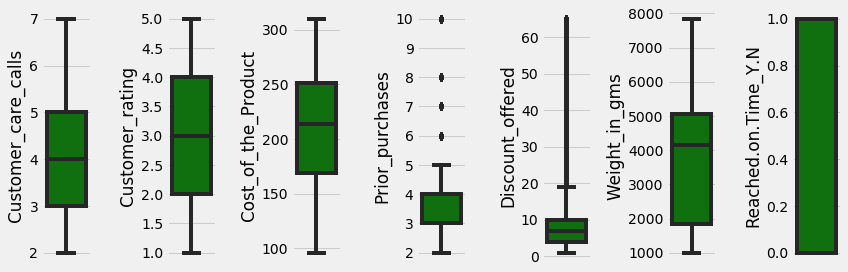

In [12]:
fig = plt.figure(figsize = (12,4))
for i in range(0, len(num_col)):
    plt.subplot(1, len(num_col), i+1)
    sns.boxplot(y=df[num_col[i]], color = 'green', orient = 'v')
    plt.tight_layout()

Pengamatan 

- Outlier terlihat utamanya pada kolom prior_purchase dan discount_offered
- Dari boxplotnya juga tampak mana distribusi yang terlihat skewed: prior_purchase dan discount_offered


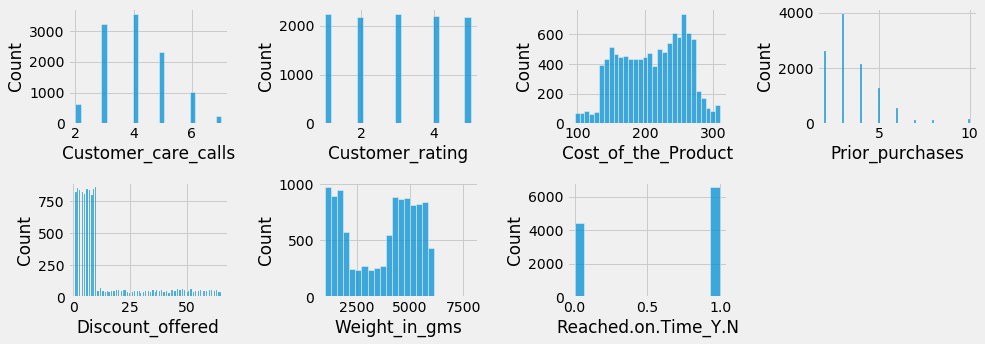

In [13]:
fig = plt.figure(figsize = (14,5))
for i in range(0, len(num_col)):
    plt.subplot(2, 4, i+1)
    sns.histplot(x = df[num_col[i]])
    plt.tight_layout()

pengamatan 

1. Kolom customer care calls terlihat sedikit skew ke kiri
2. kolom customer rating terlihat memiliki data yang flat atau rata semua sama (terlihat normal)
3. kolom cost of the product terlihat sedikit skew ke kanan
4. kolom prior purchase dan discount offered terlihat sangat skew ke kiri
5. terlihat kolom weight in gms memiliki distribusi 2 puncak (skew ke kiri)
6. kolom reached on time adalah biner, sehingga tidak perlu terlalu diperhatikan bentuk distribusinya

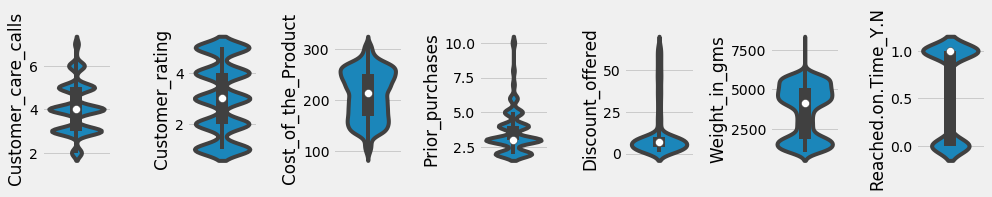

In [14]:
fig = plt.figure(figsize = (14,5))
for i in range(0, len(num_col)):
    plt.subplot(2, len(num_col), i+1)
    sns.violinplot(data = df, y = num_col[i])
    plt.tight_layout()

Categorical

In [15]:
cat_col

['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']

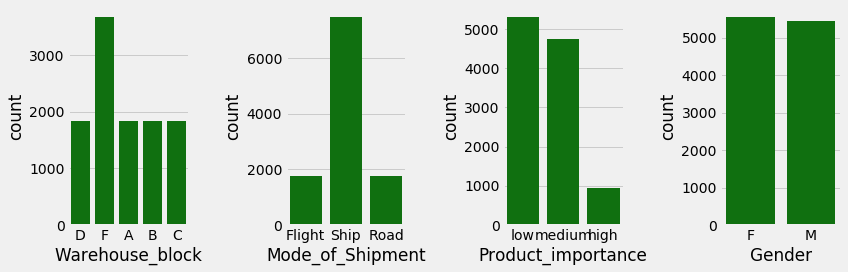

In [16]:
fig = plt.figure(figsize = (12,4))
for i in range(0, len(cat_col)):
    plt.subplot(1, len(cat_col), i+1)
    sns.countplot(x=df[cat_col[i]], color = 'green')
    plt.tight_layout()

pengamatan

1. kolom werehouse block didominasi oleh (F)
2. kolom mode of shipment didominasi olehb (Ship)
3. kolom product importance didominasi oleh 2 value (low dan medium)
4. Gender terlihat memiliki jumblah value yang sama

# Multivariate

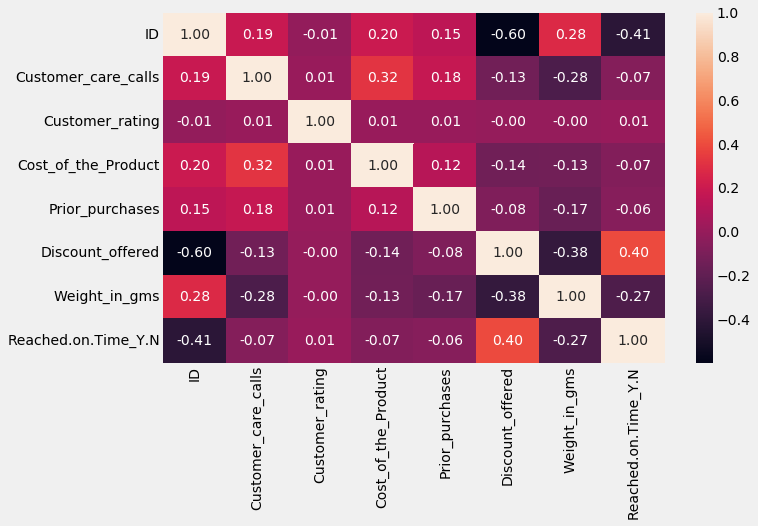

In [17]:
fig = plt.figure(figsize = (10,6))
sns.heatmap(df.corr(), annot=True, fmt = '.2f')

Dari correlation heatmap di atas dapat dilihat bahwa:

1. Targert kita Reached on time memiliki korelasi yang tinggi dengan discount offered
2. Reached on time memiliki korelasi yang sangat rendah dengan id dan weight in gms
3. discount offered juga memiliki korelasi yang sangat rendah dengan id dan weight in gms
4. cost of the produk memiliki korelasi yang lumayan tinggi dengan customer care call 

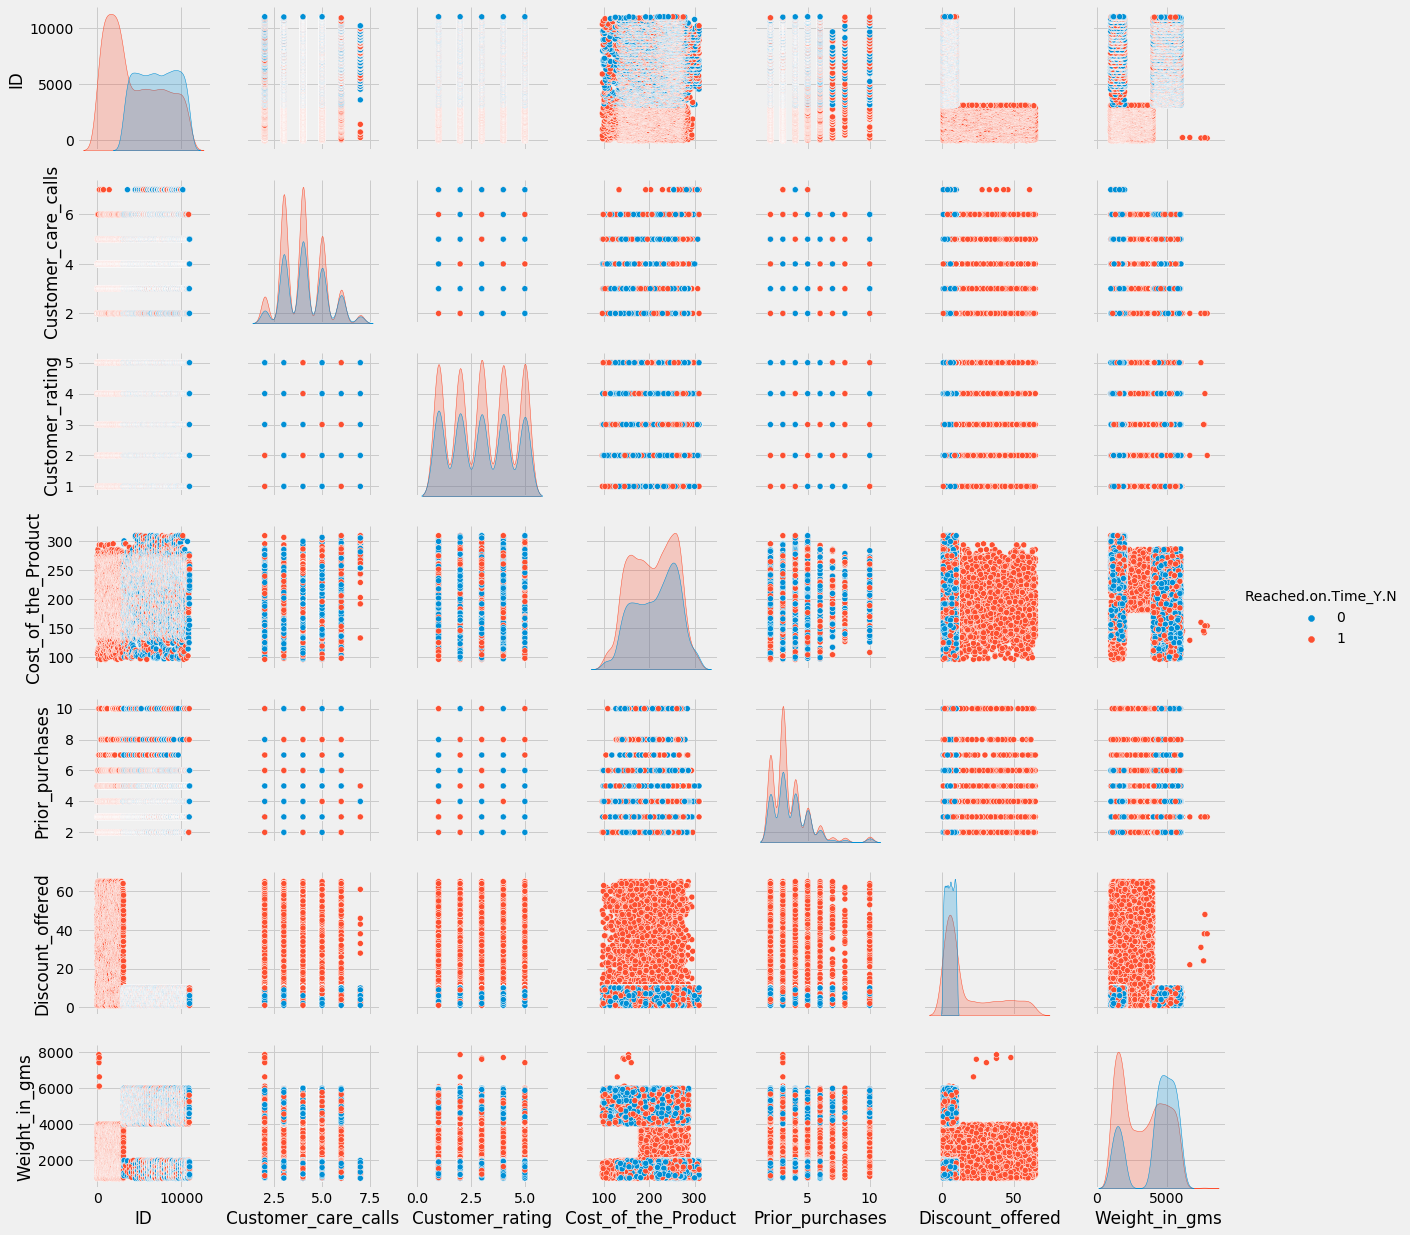

In [18]:
sns.pairplot(df, hue = 'Reached.on.Time_Y.N', diag_kind = 'kde')

Hal terjanggal: 
* Semua ID di bawah 3136 tepat waktu
* Discount di atas 10% semua tepat waktu
    * ID > 3136 diskon max 10%
* Weight di antara 2000 - 4000 dan di atas 6000 (outlayer) semua tepat waktu
    * ID < 3136 weight max 4000 gms
    * ID > 3136 tidak ada weight di antara 2000 - 4000 dan di atas 6000 gms
    * Weight di antara 2000 - 4000 cost product min 181, max 286

In [19]:
NotOnTime = df[df['Reached.on.Time_Y.N'] == 0]
OnTime = df[df['Reached.on.Time_Y.N'] == 1]

In [20]:
NotOnTime.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,4436.0,7090.479486,2278.543555,3136.0,5092.25,7096.0,9078.5,10999.0
Customer_care_calls,4436.0,4.147656,1.162771,2.0,3.00,4.0,5.0,7.0
Customer_rating,4436.0,2.967989,1.414808,1.0,2.00,3.0,4.0,5.0
Cost_of_the_Product,4436.0,214.498647,47.757432,97.0,174.00,222.0,254.0,310.0
Prior_purchases,4436.0,3.670424,1.525444,2.0,3.00,3.0,4.0,10.0
Discount_offered,4436.0,5.545987,2.877727,1.0,3.00,6.0,8.0,10.0
Weight_in_gms,4436.0,4168.668395,1573.954178,1001.0,4043.50,4674.0,5337.0,6000.0
Reached.on.Time_Y.N,4436.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0


In [21]:
NotOnTime.describe(include='O').T

,count,unique,top,freq
Warehouse_block,4436,5,F,1472
Mode_of_Shipment,4436,3,Ship,3003
Product_importance,4436,3,low,2157
Gender,4436,2,F,2249


In [22]:
OnTime.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,6563.0,4424.978364,3243.986559,1.0,1641.5,3467.0,7194.5,10995.0
Customer_care_calls,6563.0,3.991467,1.122592,2.0,3.0,4.0,5.0,7.0
Customer_rating,6563.0,3.005790,1.412692,1.0,2.0,3.0,4.0,5.0
Cost_of_the_Product,6563.0,207.289197,48.054876,96.0,167.0,209.0,249.0,310.0
Prior_purchases,6563.0,3.498095,1.517285,2.0,3.0,3.0,4.0,10.0
Discount_offered,6563.0,18.663721,19.108797,1.0,5.0,9.0,32.0,65.0
Weight_in_gms,6563.0,3272.640104,1576.148391,1001.0,1735.5,3231.0,4696.5,7846.0
Reached.on.Time_Y.N,6563.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


In [23]:
OnTime.describe(include='O').T

,count,unique,top,freq
Warehouse_block,6563,5,F,2194
Mode_of_Shipment,6563,3,Ship,4459
Product_importance,6563,3,low,3140
Gender,6563,2,F,3296


Hal terjanggal: 
* Discount di atas 10% semua tepat waktu
* Semua ID di bawah 3136 tepat waktu
* Weight di antara 2000 - 4000 dan di atas 6000 semua tepat waktu

In [24]:
filter_disc = df['Discount_offered'] <= 10
filter_ID = df['ID'] >= 3136
filter_weight = (df['Weight_in_gms'] <= 6000) & ~((df['Weight_in_gms'] < 4000) & (df['Weight_in_gms'] > 2000))

In [25]:
# All reached on time data
df[~filter_disc | ~filter_ID | ~filter_weight].describe()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,3135.000000,3135.000000,3135.000000,3135.000000,3135.000000,3135.000000,3135.000000,3135.0
mean,1568.000000,3.747687,2.978309,196.000000,3.293780,33.072727,2365.717065,1.0
std,905.140873,0.992862,1.413596,45.584357,1.505831,18.915401,923.487070,0.0
min,1.000000,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,1.0
25%,784.500000,3.000000,2.000000,158.000000,2.000000,17.000000,1568.500000,1.0
50%,1568.000000,4.000000,3.000000,192.000000,3.000000,34.000000,2236.000000,1.0
75%,2351.500000,4.000000,4.000000,234.000000,4.000000,49.000000,3136.000000,1.0
max,3135.000000,7.000000,5.000000,296.000000,10.000000,65.000000,7846.000000,1.0


In [26]:
df_filtered = df[filter_disc & filter_ID & filter_weight]
df_filtered.describe()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,7864.000000,7864.000000,7864.000000,7864.000000,7864.000000,7864.000000,7864.000000,7864.000000
mean,7067.500000,4.176755,2.995422,215.856434,3.676755,5.519964,4139.627035,0.435910
std,2270.285591,1.173508,1.413666,47.859223,1.515963,2.883134,1582.351129,0.495907
min,3136.000000,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,5101.750000,3.000000,2.000000,176.000000,3.000000,3.000000,4020.000000,0.000000
50%,7067.500000,4.000000,3.000000,223.000000,3.000000,6.000000,4657.000000,0.000000
75%,9033.250000,5.000000,4.000000,255.000000,4.000000,8.000000,5323.000000,1.000000
max,10999.000000,7.000000,5.000000,310.000000,10.000000,10.000000,6000.000000,1.000000


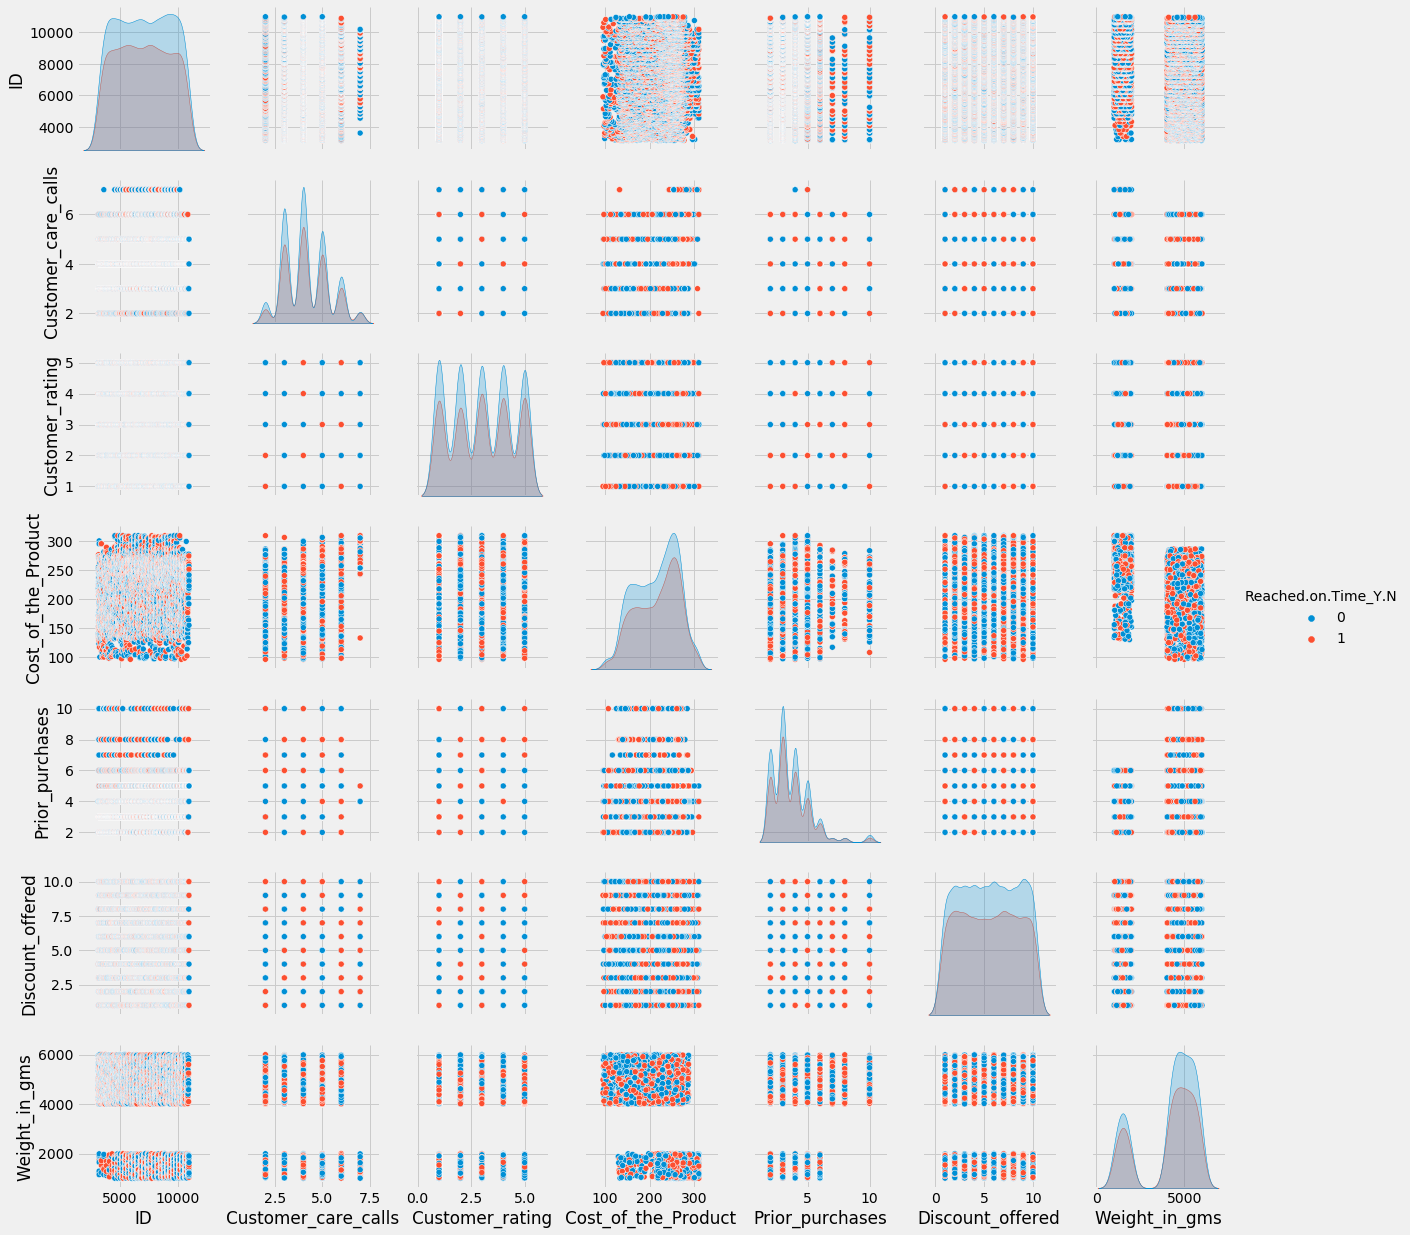

In [27]:
sns.pairplot(df_filtered, hue = 'Reached.on.Time_Y.N', diag_kind = 'kde')

In [28]:
df_filtered[cat_col].describe()

,Warehouse_block,Mode_of_Shipment,Product_importance,Gender
count,7864,7864,7864,7864
unique,5,3,3,2
top,F,Ship,low,F
freq,2621,5323,3842,3957


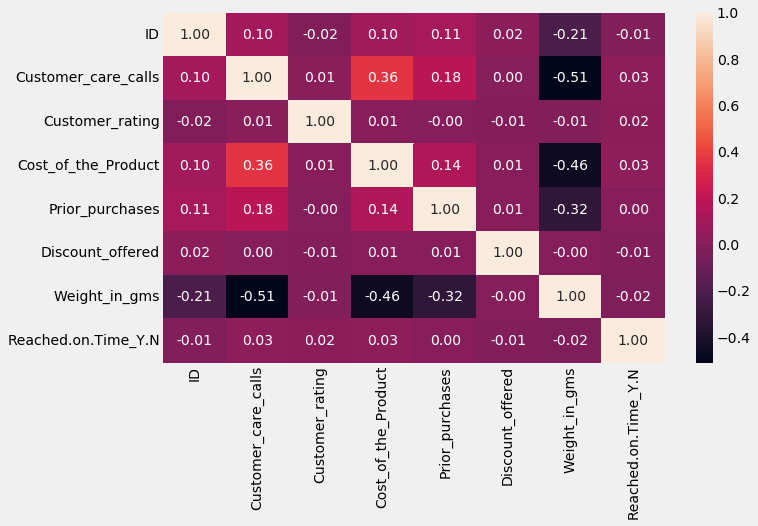

In [29]:
fig = plt.figure(figsize = (10,6))
sns.heatmap(df_filtered.corr(), annot=True, fmt = '.2f')

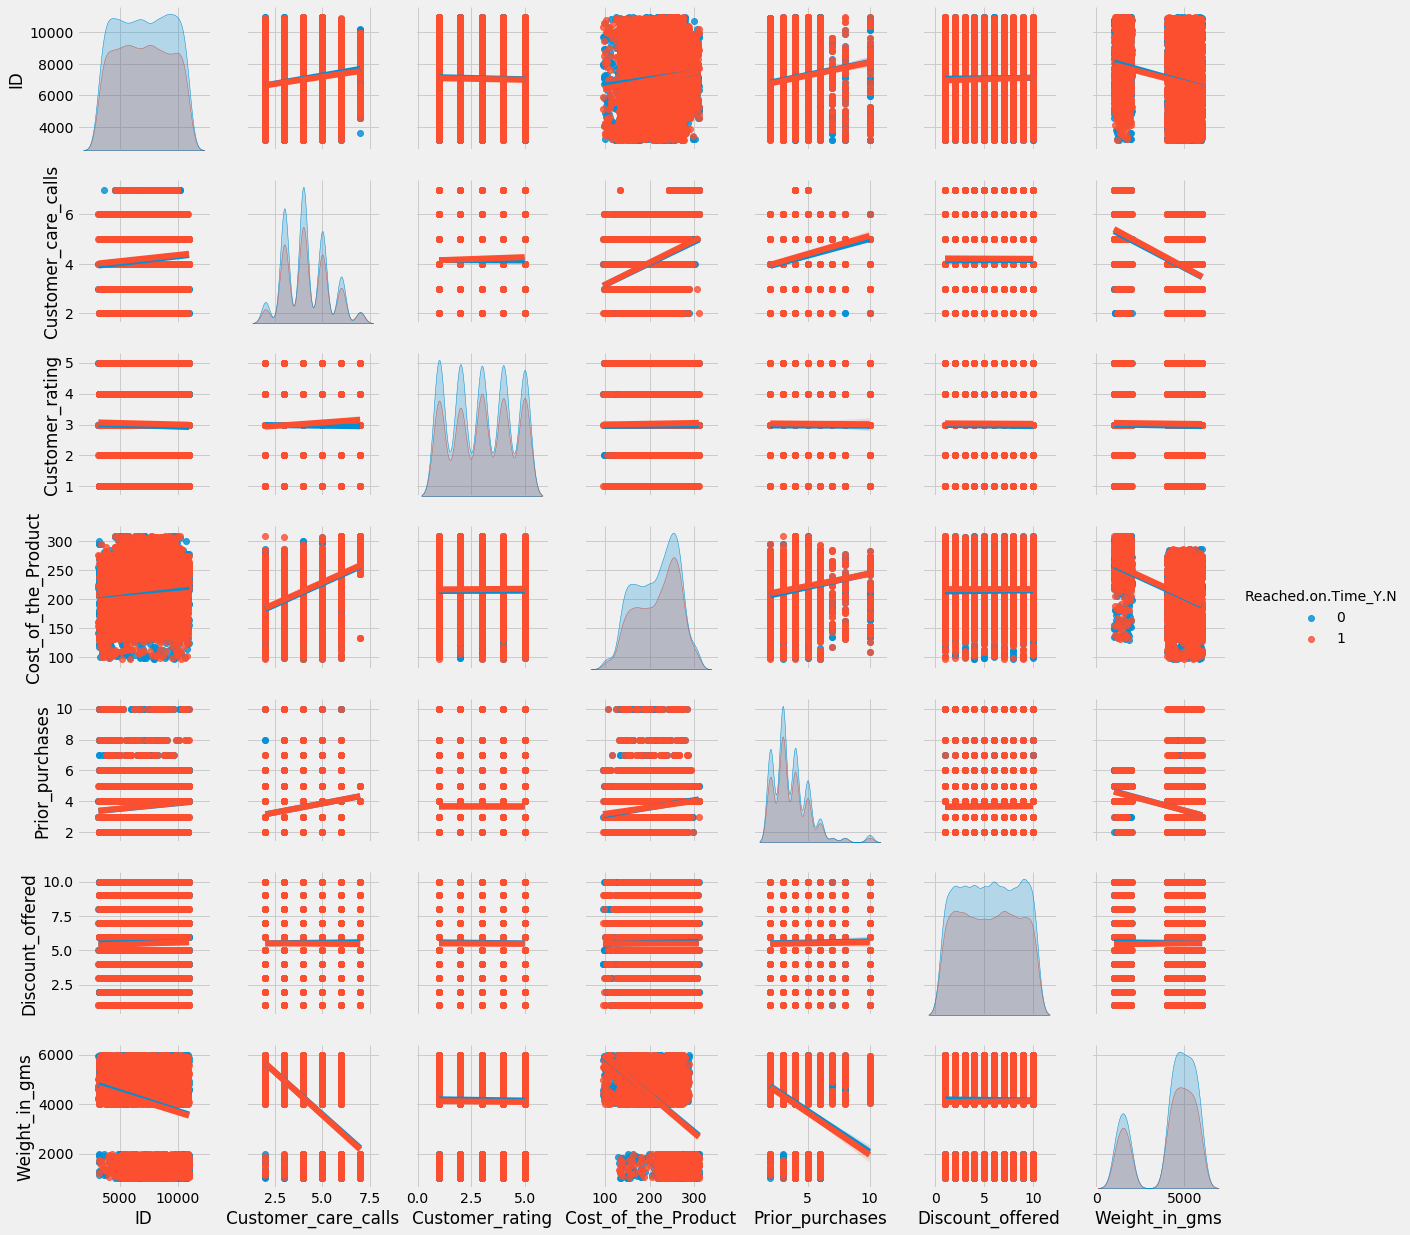

In [30]:
sns.pairplot(df_filtered, hue = 'Reached.on.Time_Y.N', diag_kind = 'kde', kind = 'reg')

In [31]:
cat_col

['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']

In [32]:
num_col

['Customer_care_calls',
 'Customer_rating',
 'Cost_of_the_Product',
 'Prior_purchases',
 'Discount_offered',
 'Weight_in_gms',
 'Reached.on.Time_Y.N']

In [33]:
def rasio_plot(data, col):
    df = data.copy()
    g = df.groupby(col)['Reached.on.Time_Y.N'].value_counts(normalize=True).unstack('Reached.on.Time_Y.N').plot(kind='barh', stacked=True)
    g.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    #g.set_ylabel('Partner Dependants Group')
    g.legend(loc='center', title = "on time?")

    for p in g.patches:
        g.annotate(format(p.get_width(), '.2%'),
                   xy = (p.get_x() + p.get_width() / 2,
                         p.get_y() + p.get_height() / 2,),
                   ha = 'center',
                   va = 'center',
                   color = 'white'
                  )
    plt.show()

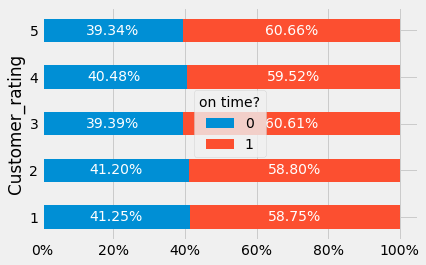

In [34]:
rasio_plot(data = df, col = 'Customer_rating')

Pengamatan 

data terlihat flat, semua value memiliki reached on time yang mirib

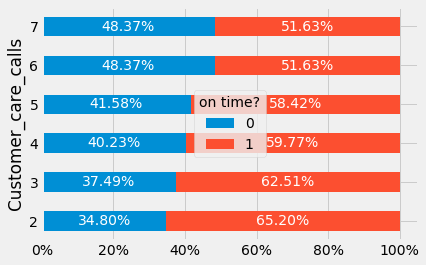

In [35]:
rasio_plot(data = df, col = 'Customer_care_calls')

pengamatan 

semakin rendah customer care call maka semakin tinggi juga reached on time (1)

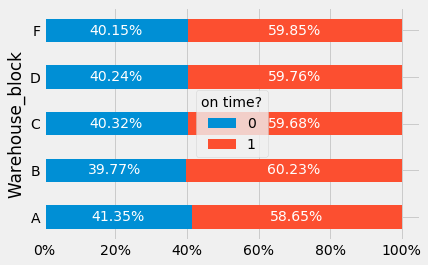

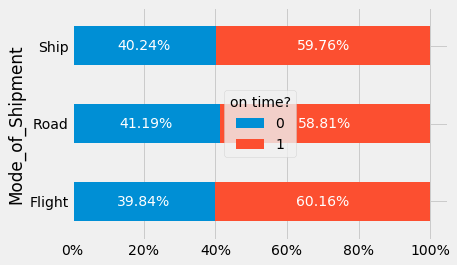

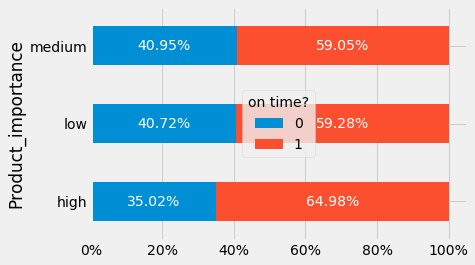

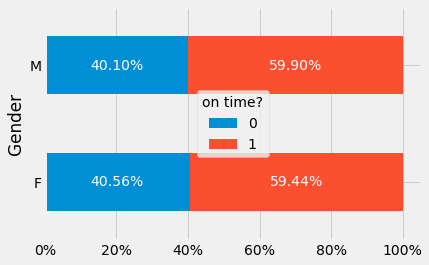

In [36]:
for col in cat_col:
    rasio_plot(data = df, col=col)

Pengamatan 

- semua data di atas terlihat flat, semua value memiliki reached on time yang mirib
- kecuali product of importance (hight) yang memiliki reached on time yang sedikit lebih tinggi 5% dari yang lain

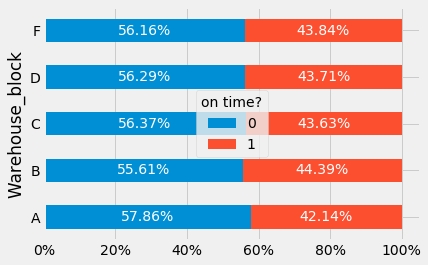

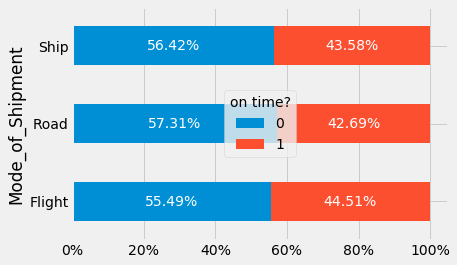

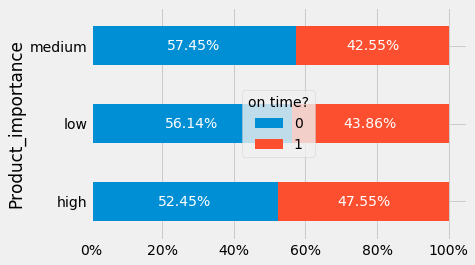

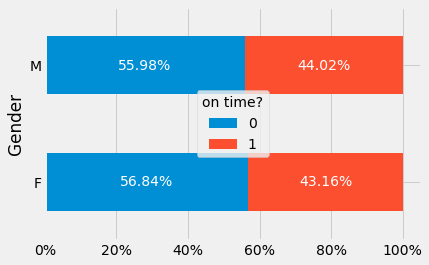

In [37]:
for col in cat_col:
    rasio_plot(data = df_filtered, col=col)

Pengamatan 

- semua data di atas terlihat flat, semua value memiliki reached on time yang mirib

# Segmentasi

Diskon:
* Under 10%
* Over 10%

Berat:
* 0 - 2 kg
* 2 - 4 kg
* 4 - 6 kg
* 6 - 8 kg

In [38]:
def segmentasi_berat(x):
    if x <= 2000:
        return 1
    elif x < 4000:
        return 2
    elif x <= 6000:
        return 3
    else: return 4

In [39]:
df['segmen_diskon'] = df['Discount_offered'].apply(lambda x: 1 if x <= 10 else 2)
df['segmen_berat'] = df['Weight_in_gms'].apply(lambda x: segmentasi_berat(x))

In [40]:
df[['segmen_diskon', 'segmen_berat']]

,segmen_diskon,segmen_berat
0,2,1
1,2,2
2,2,2
3,1,1
4,2,2
...,...,...
10994,1,1
10995,1,1
10996,1,1
10997,1,1


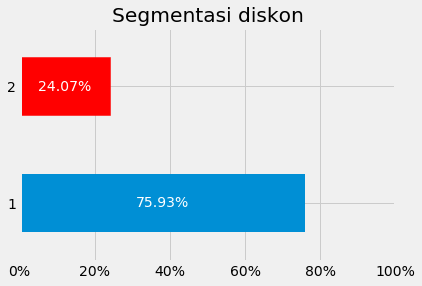

In [41]:
g = df['segmen_diskon'].value_counts(normalize = True).plot(kind='barh', stacked=True)
g.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
g.set_title('Segmentasi diskon')
g.set_xlim(0,1)
g.get_children()[1].set_color('red')
#g.legend(loc='center', title = "on time?")

for p in g.patches:
    g.annotate(format(p.get_width(), '.2%'),
               xy = (p.get_x() + p.get_width() / 2,
                     p.get_y() + p.get_height() / 2,),
               ha = 'center',
               va = 'center',
               color = 'white'
              )

In [42]:
df['segmen_diskon'].value_counts()

1    8352
2    2647
Name: segmen_diskon, dtype: int64

Diskon:
1. Under 10%
2. Over 10%

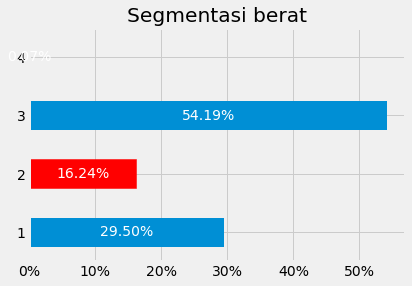

In [43]:
g = df['segmen_berat'].value_counts(normalize = True).sort_index().plot(kind='barh', stacked=True)
g.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
g.set_title('Segmentasi berat')
g.get_children()[1].set_color('red')
g.get_children()[3].set_color('red')
#g.legend(loc='center', title = "on time?")

for p in g.patches:
    g.annotate(format(p.get_width(), '.2%'),
               xy = (p.get_x() + p.get_width() / 2,
                     p.get_y() + p.get_height() / 2,),
               ha = 'center',
               va = 'center',
               color = 'white'
              )

In [44]:
df['segmen_berat'].value_counts().sort_index()

1    3245
2    1786
3    5960
4       8
Name: segmen_berat, dtype: int64

Berat:
1. 0 - 2 kg
2. 2 - 4 kg
3. 4 - 6 kg
4. 6 - 8 kg

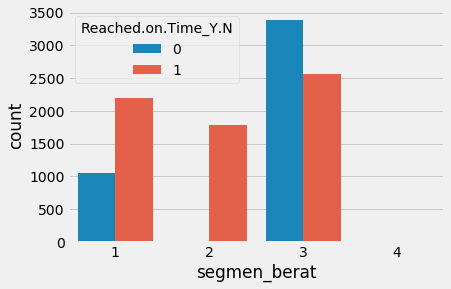

In [45]:
sns.countplot(data = df, x = 'segmen_berat', hue='Reached.on.Time_Y.N')

pengamatan 

- dari data ini bisa dilihat reached on time (0) dari weight in gms terdapat di segmen berat 1 (sekitar 9% dari populasi) dan segmen berat 3 (sekitar 31% dari populasi)
-  dan di segmen berat 2 semua valuenya memiliki reached on time (1)    

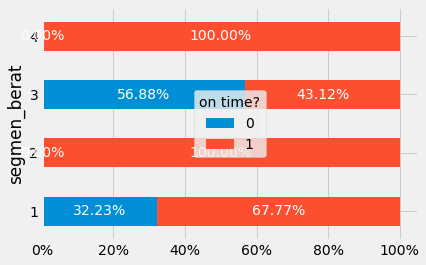

In [46]:
rasio_plot(data = df, col = 'segmen_berat')

pengamatan 

- terlihat jelas reached on time (1) dari segmen 2 dan 4 100%
- segmen 1 memiliki reached on time (0) < (1)
- segmen 3 memiliki reached on time (0) > (1)

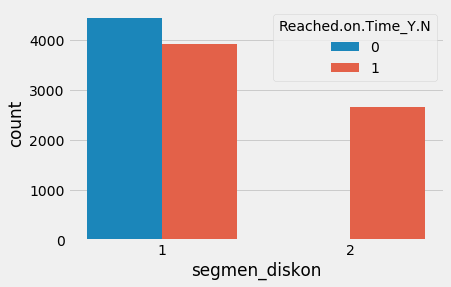

In [47]:
sns.countplot(data = df, x = 'segmen_diskon', hue='Reached.on.Time_Y.N')

pengamatan

- terlihat semua populasi yang reached on time (0) terdapan di segmen diskon 1
- dan semua populasi yang berada di segmen diskon 2 memiliki value reached on time (1)

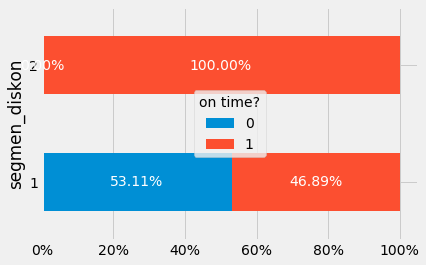

In [48]:
rasio_plot(data = df, col = 'segmen_diskon')

pengamatan 

- segmen diskon 2 memiliki values reached on time sebesar 100%